# Automating Port Operations

#### Objective
Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.
The company’s management has set out to build a bias-free/corruption-free automatic system that reports & avoids faulty situations caused by human error. Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. As a deep learning engineer, your task is to build a CNN network to classify the boat.


In [ ]:
#importing Libraries
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Explore Dataset

In [ ]:
# setting image size and batch size
IMAGE_SIZE =256
BATCH_SIZE = 32

In [ ]:
# Loading and saving the dataset
df = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/My Drive/Colab Notebooks/My AIML projects/Boat ops/training/boat',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1162 files belonging to 9 classes.


In [ ]:
# Displaying the classe sin dataset
class_names = df.class_names
print("Types of boats in dataset are : ", class_names)

Types of boats in dataset are :  ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sail_boat']


In [ ]:
#printing the imagesize in a batch and the classes of images
for image_batch, label_batch in df.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 6 1 6 4 6 4 8 4 6 1 1 8 8 1 1 6 8 8 8 4 8 0 5 2 5 8 8 1 4 3 2]


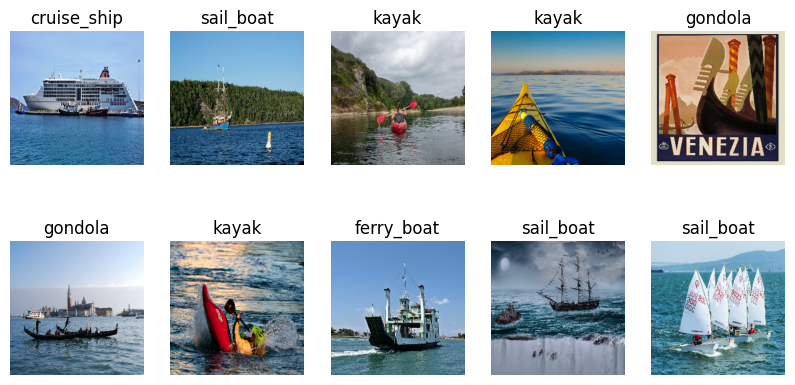

In [ ]:
# Visualizing few images in a particular batch
plt.figure(figsize= (10,5))
for image_batch, label_batch in df.take(3):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

### Modeling

In [ ]:
# defining a function for spliting the dataset
def get_dataset_parts_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle = True,shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed = 43)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [ ]:
#Splitting the dataset into training, validation and testing set
train_ds,val_ds,test_ds = get_dataset_parts_tf(df)

In [ ]:
# Optimizing datasets to improve the performance using cache
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Scaling/ Normalizing and resizing images
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Using Data Augmentation for improving robustness of model
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))

In [ ]:
# CNN Architecture
ip_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)

CNN =models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,(3,3),activation='relu',input_shape = ip_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.GlobalAveragePooling2D(),

    layers.Flatten(),

    layers.Dense(128,activation = 'relu'),
    layers.Dense(128,activation = 'relu'),

    layers.Dense(len(class_names),activation= 'softmax')
])

CNN.build(input_shape = ip_shape)

In [ ]:
# Summary of model
CNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [ ]:
# Compiling the model
CNN.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:

#Training
EPOCHS = 20

model1 = CNN.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose=1
)

Epoch 1/20
29/29 [==============================] - 141s 4s/step - loss: 1.9661 - accuracy: 0.3046 - precision_1: 0.5882 - recall_1: 0.0110 - val_loss: 1.8738 - val_accuracy: 0.2188 - val_precision_1: 1.0000 - val_recall_1: 0.0104
Epoch 2/20
29/29 [==============================] - 112s 4s/step - loss: 1.8210 - accuracy: 0.3333 - precision_1: 0.7600 - recall_1: 0.0210 - val_loss: 1.8572 - val_accuracy: 0.2188 - val_precision_1: 1.0000 - val_recall_1: 0.0208
Epoch 3/20
29/29 [==============================] - 100s 3s/step - loss: 1.8024 - accuracy: 0.3333 - precision_1: 0.8000 - recall_1: 0.0177 - val_loss: 1.8488 - val_accuracy: 0.2188 - val_precision_1: 1.0000 - val_recall_1: 0.0417
Epoch 4/20
29/29 [==============================] - 100s 4s/step - loss: 1.7924 - accuracy: 0.3300 - precision_1: 0.7895 - recall_1: 0.0166 - val_loss: 1.8725 - val_accuracy: 0.2188 - val_precision_1: 0.4737 - val_recall_1: 0.0938
Epoch 5/20
29/29 [==============================] - 80s 3s/step - loss: 1.76

In [ ]:
# Evaluating the model
scores = CNN.evaluate(test_ds)
print("Test loss, accuracy, precision and recall: : ",scores)

5/5 [==============================] - 13s 474ms/step - loss: 1.7379 - accuracy: 0.3261 - precision_1: 0.5217 - recall_1: 0.0870
Test loss, accuracy, precision and recall: :  [1.7379260063171387, 0.32608696818351746, 0.52173912525177, 0.08695652335882187]


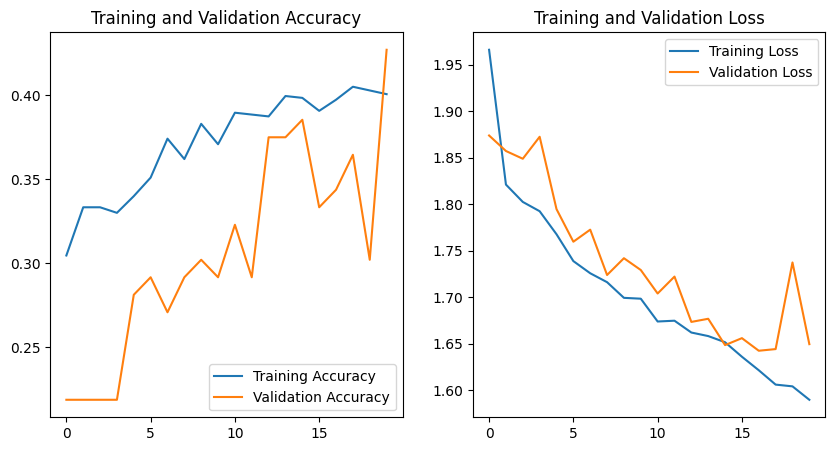

In [ ]:
#Plotting model accuracy and loss for train and validation data
acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']

loss = model1.history['loss']
val_loss = model1.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: cruise_ship
1/1 [==============================] - 1s 662ms/step
Predicted label: gondola


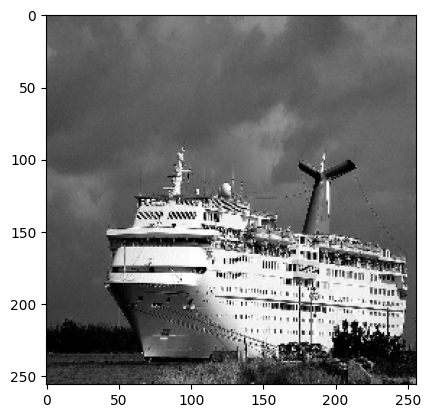

In [ ]:
#Predicting class
import numpy as np

for image_batch, label_batch in test_ds.take(1):

  first_image=image_batch[0].numpy().astype("uint8")
  first_label=label_batch[0].numpy()


  print("First image to predict")
  plt.imshow(first_image)
  plt.axis("off")
  print("Actual label:",class_names[np.argmax(first_label)])

  batch_prediction=CNN.predict(image_batch)
  print("Predicted label:",class_names[np.argmax(batch_prediction[0])])



In [ ]:
def predict(model1,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model1.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 34ms/step


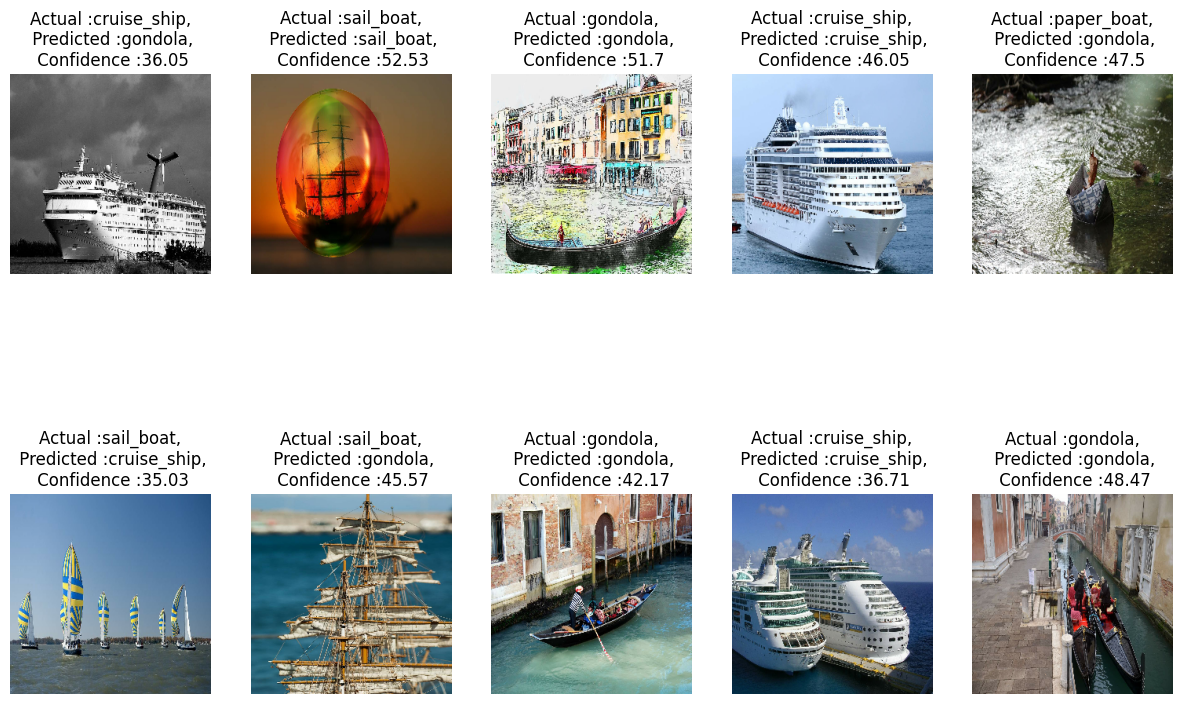

In [ ]:
plt.figure(figsize=(15,10))
for images, labels in test_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(CNN,images[i].numpy())
    actual_class=class_names[np.argmax(labels[i])]

    plt.title(f"Actual :{actual_class},\n Predicted :{predicted_class},\n Confidence :{confidence}")
    plt.axis("off")